<center><h1>Neural Network - Street View House Number (SVHN)</h1></center>

## <u>Description</u>
The goal of this hands-on project is to build a classifier model from scratch to understand the nitty gritties of building and training a model and further to understand the advantages of neural networks. First we will implement a simple KNN classifier and later implement a Neural Network to classify the images in the SVHN dataset. We will compare the computational efficiency and accuracy between the traditional method (k-Nearest Neighbor) and neural networks.

## <u>Dataset Information</u>
The **Street View House Number (SVHN)** dataset is a real-world image dataset for developing machine learning and object recognition algorithms with minimal requirement on data formatting but comes from a significantly harder, unsolved, real world problem (recognizing digits and numbers in natural scene images). SVHN is obtained from house numbers in Google Street View images.

SVHN identification is a difficult problem. The main challenges are often decomposed into three subproblems: (i) finding the number on the house, (ii) segmenting the individual digits, and (iii) classifying the digits. Each of these subproblems is difficult, for different reasons. Localization is a challenge because numbers are hard to distinguish from other shapes; segmentation is difficult because the digits are often close together (and sometimes even connected); and classification is difficult because there is a massive variety in the typefaces, textures and colours present in house numbers.

We'll be working on the 3rd format of the problem which is to classify 32x32 images centered around a single character (many of the images do contain some distractors at the sides).

---
## <u>Imports and Configurations</u>

In [1]:
# Utilities
import sys
import h5py
import warnings
from time import time

# Numerical calculation
import numpy as np

# Data handling
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Conventional ML Model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Neural Network
from tensorflow.keras import utils, losses, optimizers, callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, ReLU, Dense, BatchNormalization

In [2]:
# Configure for any default setting of any library
np.random.seed(5)
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## <u>Load and Visualize the Data</u>
This notebook is made generic to run in both Google Colab and in local workstation. Load the h5 file and visualize the data in it.

In [3]:
svhn_file = 'SVHN_single_grey1.h5'
if 'google.colab' in sys.modules:    
    # Google Colab lib
    from google.colab import drive
    # Mount the drive
    drive.mount('/content/drive/')
    # Open the drive file as readonly
    svhn = h5py.File('/content/drive/My Drive/Colab Notebooks/DLCP/' + svhn_file, 'r')
else:
    # Open the local file as readonly
    svhn = h5py.File(svhn_file, 'r')

In [4]:
# Load the training, validation and test sets
X_train_o = svhn['X_train'][:]
X_test_o = svhn['X_test'][:]
X_val_o = svhn['X_val'][:]
y_train_o = svhn['y_train'][:]
y_test_o = svhn['y_test'][:]
y_val_o = svhn['y_val'][:]

print('Shape of different datasets are:')
print('X_train :', X_train_o.shape)
print('X_test  :', X_test_o.shape)
print('X_val   :', X_val_o.shape)
print('y_train :', y_train_o.shape)
print('y_test  :', y_test_o.shape)
print('y_val   :', y_val_o.shape)

Shape of different datasets are:
X_train : (42000, 32, 32)
X_test  : (18000, 32, 32)
X_val   : (60000, 32, 32)
y_train : (42000,)
y_test  : (18000,)
y_val   : (60000,)


Labels corresponding to below images: [2 6 7 4 4 0 3 0 7 3 1 0 1 3 1]


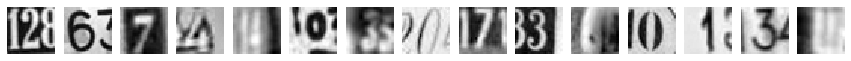

In [5]:
# visualizing the first 15 images in the dataset and their labels
print('Labels corresponding to below images: %s' % (y_train_o[0:15]))
plt.figure(figsize=(15, 1))
for i in range(15):
    plt.subplot(1, 15, i+1)
    plt.imshow(X_train_o[i], cmap="gray")
    plt.axis('off')

## <u>Preprocess the Image</u>

The images are gray-scaled images with 32x32 pixels each of 1 byte in size. So the values containing in each pixel ranges from $0$ to $2^8-1 = 255$. In order to feed them into Neural Network we must convert the input matrix to 1-D vector. Hence as part of this preprocessing step, we will do the following
- Flatteing
- Normalization

In [6]:
# Flatten the X_* datasets
X_train_f = X_train_o.reshape(X_train_o.shape[0], X_train_o.shape[1] * X_train_o.shape[2]).astype('float32')
X_test_f = X_test_o.reshape(X_test_o.shape[0], X_test_o.shape[1] * X_test_o.shape[2]).astype('float32')
X_val_f = X_val_o.reshape(X_val_o.shape[0], X_val_o.shape[1] * X_val_o.shape[2]).astype('float32')

print('Shape after flattening:')
print('X_train :', X_train_f.shape)
print('X_test  :', X_test_f.shape)
print('X_val   :', X_val_f.shape)

Shape after flattening:
X_train : (42000, 1024)
X_test  : (18000, 1024)
X_val   : (60000, 1024)


In [7]:
# Normalize the inputs from 0-255 to 0-1
X_train = X_train_f / 255.0
X_test = X_test_f / 255.0
X_val = X_val_f / 255.0

print(X_train)

[[0.12968785 0.11866706 0.10530196 ... 0.19477727 0.19942354 0.20799099]
 [0.34101608 0.3414451  0.34656274 ... 0.29498273 0.30054745 0.31092745]
 [0.48284313 0.49356118 0.47872823 ... 0.36837214 0.41093138 0.44637334]
 ...
 [0.6042902  0.61100274 0.6149663  ... 0.52993256 0.53592    0.5398412 ]
 [0.8137075  0.8176286  0.8353796  ... 0.83974785 0.8319055  0.820142  ]
 [0.37285647 0.37677765 0.39246237 ... 0.5414914  0.5509529  0.5509529 ]]


## <u>Understand the target classes</u>
Let's understand diversity, datatypes and distribution of the target classes.

In [8]:
# Get unique values in target sets
np.unique(y_train_o)
np.unique(y_test_o)
np.unique(y_val_o)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

All datasets contain unsigned int8 type target class values 0-9. Let's convert them into categorical and check their distribution.

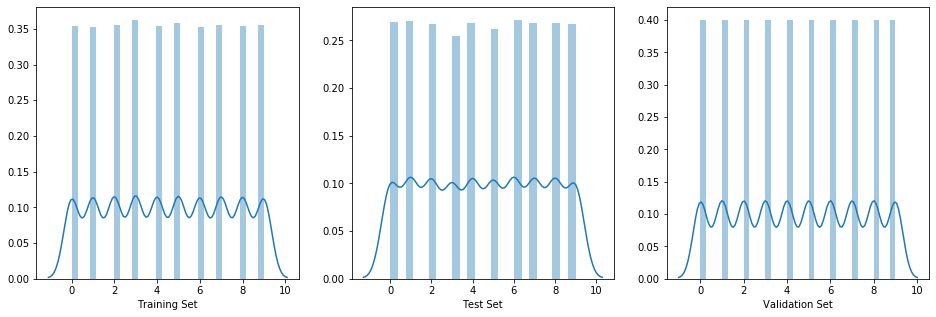

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(16,5))
sns.distplot(y_train_o, ax=axes[0], axlabel='Training Set')
sns.distplot(y_test_o, ax=axes[1], axlabel='Test Set')
sns.distplot(y_val_o, ax=axes[2], axlabel='Validation Set')

In [10]:
# Apply One-Hot-Encoding
y_train = utils.to_categorical(y_train_o)
y_test = utils.to_categorical(y_test_o)
y_val = utils.to_categorical(y_val_o)

print('Shape of different target sets are:')
print('y_train :', y_train.shape)
print('y_test  :', y_test.shape)
print('y_val   :', y_val.shape)

Shape of different target sets are:
y_train : (42000, 10)
y_test  : (18000, 10)
y_val   : (60000, 10)


## <u>k-Nearest Neighbor Model</u>
We will now consider a subset of the data for KNN classification. K Nearest neighbours classification is a traditional ML model building. We will analyze it is pertinence in the context of OCR.

In [11]:
# Take a subset of the original dataset to estimate for the best k
X_train_sub = X_train[:3000]
y_train_sub = y_train_o[:3000]
X_test_sub = X_test[:1000]
y_test_sub = y_test_o[:1000]

In [12]:
# Find accuracy scores for 30 iterations
st = time()
acc_scores = []
for k in range(1,31):
    knn = KNeighborsClassifier(n_neighbors=k , weights='uniform', metric='euclidean')
    knn.fit(X_train_sub, y_train_sub)
    acc_scores.append(accuracy_score(y_test_sub, knn.predict(X_test_sub)) * 100)
    
print('Time taken:', time()-st)
print('Scores out of 30 iterations:', np.round(acc_scores, 1))

Time taken: 236.9553999900818
Scores out of 30 iterations: [32.1 30.7 30.7 33.6 33.3 33.6 32.8 34.4 34.6 34.3 34.5 34.6 34.4 35.4
 34.7 35.8 35.4 35.5 35.  34.8 34.8 34.  33.3 34.1 33.5 33.2 33.6 33.2
 33.2 33.1]


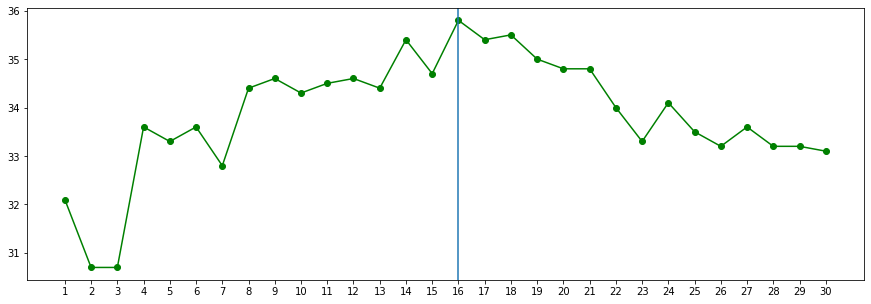

In [13]:
# Plot the accuracy scores
plt.figure(figsize=(15,5))
plt.plot(range(1,31), acc_scores , '-go')
_ = plt.xticks(range(1,31))
plt.axvline(np.argmax(acc_scores) + 1)

The accuracy score seems to be the best at 35.8% for k value of 16. Let's set the k value to 16 and train a model with the entire training dataset.

In [14]:
# Create the classifier model using the best k found among 30 iterations
st = time()
clf = KNeighborsClassifier(n_neighbors= np.argmax(acc_scores) + 1)
clf.fit(X_train, y_train_o)

predictions = clf.predict(X_test)
print('Time taken:', time()-st)

Time taken: 1905.5412249565125


In [15]:
# Classification Report
print("EVALUATION ON TESTING DATA")
print(classification_report(y_test_o, predictions))

EVALUATION ON TESTING DATA
              precision    recall  f1-score   support

           0       0.44      0.69      0.54      1814
           1       0.47      0.73      0.57      1828
           2       0.61      0.55      0.58      1803
           3       0.45      0.43      0.44      1719
           4       0.66      0.65      0.65      1812
           5       0.51      0.39      0.44      1768
           6       0.49      0.41      0.44      1832
           7       0.71      0.62      0.66      1808
           8       0.46      0.36      0.40      1812
           9       0.56      0.42      0.48      1804

    accuracy                           0.53     18000
   macro avg       0.54      0.52      0.52     18000
weighted avg       0.54      0.53      0.52     18000



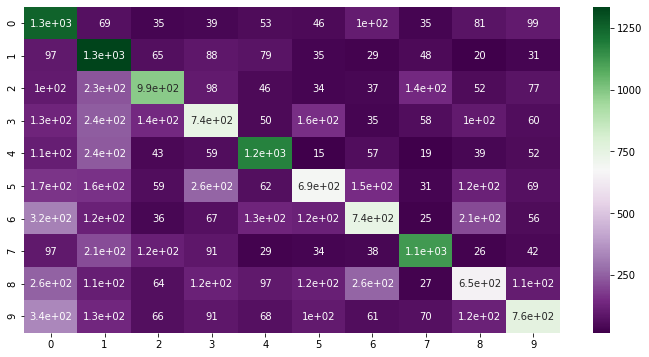

In [16]:
# Visualize the Confusion Matrix
plt.figure(figsize=(12,6))
sns.heatmap(confusion_matrix(y_test_o, predictions), annot=True, cmap="PRGn")

**Observations:**
- Accuracy of 53% shows KNN performed very poorly.
- The process with all 42000 images in the training data and 18000 images in test data took more than 30 minutes to execute. 

This is one of the obvious reasons the traditional classification models are not used for OCR. Let's build a **Deep Neural Network** classifier and compare the performance.
## <u>Neural Network Model</u>
A Neural Network, unlike traditional ML algorithms, is a series of algorithms that endeavors to recognize underlying relationships in a set of data through a process that mimics the way the human brain operates. Neural networks can adapt to changing input; so the network generates the best possible result without needing to redesign the output criteria.

Let's define a generic method to architect the network based on a layers array.

In [17]:
# Generic method to Build the Neural Network
def NNModel(layers):
    # Create model
    network = Sequential()
    # Add the layers
    if layers:
        for layer in layers:
            network.add(layer['layer_type'](**layer['params']))
    return network

<h4>Initialize Tensorboard callback for visualization of training</h4>

In [18]:
# Setting the directory to store the log file
# tb_callback = callbacks.TensorBoard(log_dir='.logs/{}'.format(time()), 
#                                     histogram_freq=0, 
#                                     write_graph=True, 
#                                     write_images=True)

<h4>Initialize Early Stopping and Model Checkpoint callbacks</h4>

In [19]:
# Stop if the val_loss is not changing even 0.001 for more than 10 continious epochs
es_callback = callbacks.EarlyStopping(monitor='val_loss', 
                                      min_delta=0.001, 
                                      patience=10)

# Saving the best weights - Saves the weights when the val_loss achieves a new low value
# mc_callback = callbacks.ModelCheckpoint('SVHN_checkpoint_{epoch:02d}_loss{val_loss:.4f}.h5',
#                                         monitor='val_loss',
#                                         verbose=1,
#                                         save_best_only=True,
#                                         mode='auto')

## Iteration - 1
Consists of Layers:
- Dense -> 256/ReLU
- Dense -> 64/ReLU
- Dense -> 32/ReLU
- Dense -> 10/Softmax (Output)

Learning Rate: 0.005<br/>
Momentum: 0.02<br/>
Epochs: 30<br/>
Batch Size: 200<br/>
Optimizer: SGD<br/>
Loss: Categorical Crossentropy

<h4>Define the Layers</h4>

In [20]:
# Define the layers for Iteration - 1
layers = [
    {
        'layer_type': Dense,
        'params': {
            'units': 256,
            'activation': 'relu'
        }
    },{
        'layer_type': Dense,
        'params': {
            'units': 64,
            'activation': 'relu'
        }
    },{
        'layer_type': Dense,
        'params': {
            'units': 64,
            'activation': 'relu'
        }
    },{
        'layer_type': Dense,
        'params': {
            'units': len(np.unique(y_train_o)),
            'activation': 'softmax'
        }
    }
]

# Build network architecture
model1 = NNModel(layers)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


<h4>Set Optimizer and Loss function for training</h4>

In [21]:
learning_rate = 5e-3
momentum = 2e-2

# Optimizer = SGD, Loss function = Categorical cross entropy
model1.compile(optimizer = optimizers.SGD(learning_rate, momentum), 
              loss = losses.categorical_crossentropy, 
              metrics=['accuracy'])

<h4>Train the network</h4>

In [22]:
epochs = 30
batch_size = 200

# Start training the network
st = time()
model1.fit(X_train, y_train, 
          validation_data=(X_val, y_val), 
          epochs=epochs, 
          batch_size=batch_size, 
          verbose=2,
          callbacks=[es_callback])
print('\nTotal time taken:', time()-st)

Train on 42000 samples, validate on 60000 samples
Epoch 1/30
42000/42000 - 3s - loss: 2.3061 - acc: 0.1137 - val_loss: 2.2969 - val_acc: 0.1171
Epoch 2/30
42000/42000 - 2s - loss: 2.2945 - acc: 0.1312 - val_loss: 2.2908 - val_acc: 0.1432
Epoch 3/30
42000/42000 - 2s - loss: 2.2890 - acc: 0.1503 - val_loss: 2.2856 - val_acc: 0.1583
Epoch 4/30
42000/42000 - 2s - loss: 2.2832 - acc: 0.1688 - val_loss: 2.2800 - val_acc: 0.1638
Epoch 5/30
42000/42000 - 2s - loss: 2.2774 - acc: 0.1839 - val_loss: 2.2739 - val_acc: 0.1927
Epoch 6/30
42000/42000 - 2s - loss: 2.2711 - acc: 0.2009 - val_loss: 2.2673 - val_acc: 0.2006
Epoch 7/30
42000/42000 - 2s - loss: 2.2636 - acc: 0.2145 - val_loss: 2.2588 - val_acc: 0.2310
Epoch 8/30
42000/42000 - 2s - loss: 2.2548 - acc: 0.2311 - val_loss: 2.2495 - val_acc: 0.2327
Epoch 9/30
42000/42000 - 2s - loss: 2.2449 - acc: 0.2424 - val_loss: 2.2387 - val_acc: 0.2591
Epoch 10/30
42000/42000 - 3s - loss: 2.2334 - acc: 0.2568 - val_loss: 2.2268 - val_acc: 0.2618
Epoch 11/

In [23]:
# Print the Summary of the Network
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  262400    
_________________________________________________________________
dense_1 (Dense)              multiple                  16448     
_________________________________________________________________
dense_2 (Dense)              multiple                  4160      
_________________________________________________________________
dense_3 (Dense)              multiple                  650       
Total params: 283,658
Trainable params: 283,658
Non-trainable params: 0
_________________________________________________________________


**Observations:**
- This is a 4 layer neural network without any regularization techniques applied.
- Though the score is better than traditional ML algorithm (k-NN), it is still **not an acceptable performance**.
- The network **needs to be optimized** in order to better learn the patterns in the dataset.
- So let's add Batch Norm & Dropout layers and use Adam optimizer in the next iteration.

## Iteration - 2
Consists of layers:
- BatchNormalization -> (1024,)
- Dropout -> 0.25
- Dense -> 256/ReLU
- BatchNormalization -> (256,)
- Dense -> 64/ReLU
- Dropout -> 0.2
- Dense -> 32/ReLU
- Dense -> 10/Softmax (Output)

Learning Rate: 0.001<br/>
Epochs: 30<br/>
Batch Size: 150<br/>
Optimizer: Adam<br/>
Loss: Categorical Crossentropy

<h4>Define the Layers</h4>

In [24]:
# Define the layers for Iteration - 2
layers = [
    {
        'layer_type': BatchNormalization,
        'params': {
            'input_shape': (1024,)
        }
    },{
        'layer_type': Dropout,
        'params': {
            'rate': 0.25
        }
    },{
        'layer_type': Dense,
        'params': {
            'units': 256,
            'activation': 'relu'
        }
    },{
        'layer_type': BatchNormalization,
        'params': {
            'input_shape': (256,)
        }
    },{
        'layer_type': Dense,
        'params': {
            'units': 64,
            'activation': 'relu'
        }
    },{
        'layer_type': Dropout,
        'params': {
            'rate': 0.2
        }
    },{
        'layer_type': Dense,
        'params': {
            'units': 32,
            'activation': 'relu'
        }
    },{
        'layer_type': Dense,
        'params': {
            'units': len(np.unique(y_train_o)),
            'activation': 'softmax'
        }
    }
]

# Build network architecture
model2 = NNModel(layers)

<h4>Set Optimizer and Loss function for training</h4>

In [25]:
learning_rate = 1e-3

# Optimizer = Adam, Loss function = Categorical cross entropy
model2.compile(optimizer = optimizers.Adam(lr=learning_rate),
              loss = losses.categorical_crossentropy, 
              metrics=['accuracy'])

<h4>Train the network</h4>

In [26]:
epochs = 30
batch_size = 150

# Start training the network
st = time()
model2.fit(X_train, y_train, 
          validation_data=(X_val, y_val),
          epochs=epochs, 
          batch_size=batch_size, 
          verbose=2,
          callbacks=[es_callback])
print('\nTotal time taken:', time()-st)

Train on 42000 samples, validate on 60000 samples
Epoch 1/30
42000/42000 - 5s - loss: 1.7014 - acc: 0.4151 - val_loss: 1.2227 - val_acc: 0.6474
Epoch 2/30
42000/42000 - 4s - loss: 1.1889 - acc: 0.6141 - val_loss: 0.8851 - val_acc: 0.7340
Epoch 3/30
42000/42000 - 4s - loss: 1.0480 - acc: 0.6621 - val_loss: 0.7811 - val_acc: 0.7617
Epoch 4/30
42000/42000 - 4s - loss: 0.9485 - acc: 0.6964 - val_loss: 0.7235 - val_acc: 0.7770
Epoch 5/30
42000/42000 - 5s - loss: 0.8892 - acc: 0.7155 - val_loss: 0.6638 - val_acc: 0.7986
Epoch 6/30
42000/42000 - 4s - loss: 0.8368 - acc: 0.7310 - val_loss: 0.6180 - val_acc: 0.8118
Epoch 7/30
42000/42000 - 4s - loss: 0.8026 - acc: 0.7420 - val_loss: 0.5789 - val_acc: 0.8237
Epoch 8/30
42000/42000 - 4s - loss: 0.7668 - acc: 0.7519 - val_loss: 0.5620 - val_acc: 0.8274
Epoch 9/30
42000/42000 - 4s - loss: 0.7489 - acc: 0.7596 - val_loss: 0.5517 - val_acc: 0.8291
Epoch 10/30
42000/42000 - 4s - loss: 0.7215 - acc: 0.7681 - val_loss: 0.5203 - val_acc: 0.8432
Epoch 11/

In [27]:
# Print the Summary of the Network
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               262400    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_5 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)               

**Observations:**
- Adding the batch norm layer and dropout layer increased the performance significantly.
- However, the difference in the training accuracy and validation accuracy indicates the network is somewhat overfit.
- Hence, let's drop 1 batch norm and 1 dropout layer in next iteration.
- Also increase the epoch size to 50 in next iteration and see how it performs.

## Iteration - 3
Consists of layers:
- BatchNormalization -> (1024,)
- Dense -> 256/ReLU
- Dense -> 64/ReLU
- Dropout -> 0.2
- Dense -> 32/ReLU
- Dense -> 10/Softmax (Output)

Learning Rate: 0.001<br/>
Epochs: 50<br/>
Batch Size: 150<br/>
Optimizer: Adam<br/>
Loss: Categorical Crossentropy

<h4>Define the Layers</h4>

In [28]:
# Define the layers for Iteration - 3
layers = [
    {
        'layer_type': BatchNormalization,
        'params': {
            'input_shape': (1024,)
        }
    },{
        'layer_type': Dense,
        'params': {
            'units': 256,
            'activation': 'relu'
        }
    },{
        'layer_type': Dense,
        'params': {
            'units': 64,
            'activation': 'relu'
        }
    },{
        'layer_type': Dropout,
        'params': {
            'rate': 0.2
        }
    },{
        'layer_type': Dense,
        'params': {
            'units': 32,
            'activation': 'relu'
        }
    },{
        'layer_type': Dense,
        'params': {
            'units': len(np.unique(y_train_o)),
            'activation': 'softmax'
        }
    }
]

# Build network architecture
model3 = NNModel(layers)

<h4>Set Optimizer and Loss function for training</h4>

In [29]:
learning_rate = 1e-3

# Optimizer = Adam, Loss function = Categorical cross entropy
model3.compile(optimizer = optimizers.Adam(lr=learning_rate), 
              loss = losses.categorical_crossentropy, 
              metrics=['accuracy'])

<h4>Train the network</h4>

In [30]:
epochs = 50
batch_size = 150

# Start training the network
st = time()
model3.fit(X_train, y_train, 
          validation_data=(X_val, y_val), 
          epochs=epochs, 
          batch_size=batch_size, 
          verbose=2,
          callbacks=[es_callback])
print('\nTotal time taken:', time()-st)

Train on 42000 samples, validate on 60000 samples
Epoch 1/50
42000/42000 - 5s - loss: 1.6752 - acc: 0.4202 - val_loss: 1.2306 - val_acc: 0.6542
Epoch 2/50
42000/42000 - 4s - loss: 1.1047 - acc: 0.6498 - val_loss: 0.8804 - val_acc: 0.7274
Epoch 3/50
42000/42000 - 5s - loss: 0.9426 - acc: 0.7029 - val_loss: 0.7999 - val_acc: 0.7505
Epoch 4/50
42000/42000 - 4s - loss: 0.8468 - acc: 0.7328 - val_loss: 0.6713 - val_acc: 0.7952
Epoch 5/50
42000/42000 - 4s - loss: 0.7741 - acc: 0.7561 - val_loss: 0.6353 - val_acc: 0.8054
Epoch 6/50
42000/42000 - 4s - loss: 0.7152 - acc: 0.7757 - val_loss: 0.5861 - val_acc: 0.8193
Epoch 7/50
42000/42000 - 4s - loss: 0.6668 - acc: 0.7911 - val_loss: 0.5562 - val_acc: 0.8303
Epoch 8/50
42000/42000 - 4s - loss: 0.6384 - acc: 0.8009 - val_loss: 0.5424 - val_acc: 0.8350
Epoch 9/50
42000/42000 - 4s - loss: 0.6069 - acc: 0.8085 - val_loss: 0.5007 - val_acc: 0.8485
Epoch 10/50
42000/42000 - 4s - loss: 0.5736 - acc: 0.8190 - val_loss: 0.4977 - val_acc: 0.8481
Epoch 11/

In [31]:
# Print the Summary of the Network
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_2 (Batch (None, 1024)              4096      
_________________________________________________________________
dense_8 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_9 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_11 (Dense)             (None, 10)                330       
Total params: 285,354
Trainable params: 283,306
Non-trainable params: 2,048
____________________________________________

**Observations:**
- This network consists of 4 dense layers along with one batch norm layer and one dropout layer.
- The performance of this network is also very good with 90% train accuracy and 91% of validation accuracy.

<h4>It is noticed that the network in iteration 3 performed very well. Hence we will consider this model3 to evaluate the SVHN dataset.</h4>

## <u>Evaluate the Neural Network</u>

<h4>Evaluate trained model on test data</h4>

In [34]:
# Testing the model on test set
predictions = model3.predict_classes(X_test)
score = model3.evaluate(X_test, y_test)
print('Test loss      :', score[0])
print('Test accuracy  :', score[1])

18000/18000 [==============================] - 1s 52us/sample - loss: 0.5401 - acc: 0.8591
Test loss      : 0.5400900061130524
Test accuracy  : 0.8590556


In [35]:
# Classification Report
print("EVALUATION ON TESTING DATA")
print(classification_report(y_test_o, predictions))

EVALUATION ON TESTING DATA
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1814
           1       0.84      0.89      0.86      1828
           2       0.86      0.89      0.87      1803
           3       0.83      0.81      0.82      1719
           4       0.89      0.89      0.89      1812
           5       0.87      0.83      0.85      1768
           6       0.85      0.86      0.86      1832
           7       0.88      0.87      0.88      1808
           8       0.86      0.81      0.83      1812
           9       0.85      0.85      0.85      1804

    accuracy                           0.86     18000
   macro avg       0.86      0.86      0.86     18000
weighted avg       0.86      0.86      0.86     18000



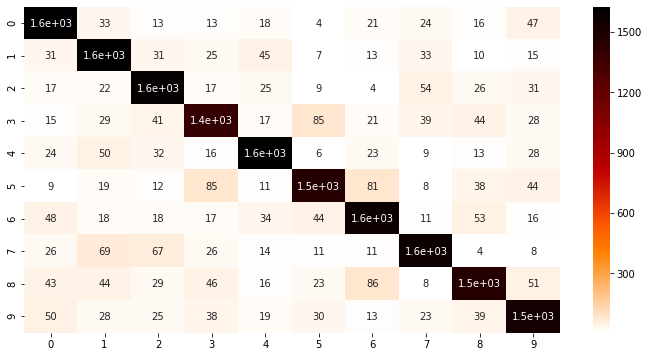

In [36]:
# Visualize the Confusion Matrix
plt.figure(figsize=(12,6))
sns.heatmap(confusion_matrix(y_test_o, predictions), annot=True, cmap="gist_heat_r")

<h4>Visualizing some predictions</h4>

Actual labels corresponding to below images: [1 7 2 9 0 9 1 8 4 4 8 9 1 4 3]
Predicted labels corresponding to below images: [1 7 2 9 0 9 1 3 1 4 8 3 1 4 3]


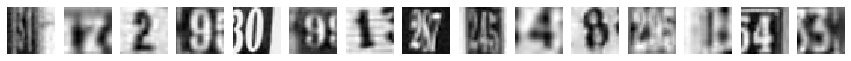

In [37]:
# visualizing the first 15 images in the dataset and their labels
print('Actual labels corresponding to below images: %s' % (y_test_o[0:15]))
plt.figure(figsize=(15, 1))
for i in range(15):
    plt.subplot(1, 15, i+1)
    plt.imshow(X_test_o[i], cmap="gray")
    plt.axis('off')
    
print('Predicted labels corresponding to below images: %s' % (predictions[0:15]))

## <u>Saving the Model</u>

In [38]:
# Set the paths to store the model and weights
model3.save('SVHN_DeepNN_model.h5')
model3.save_weights('SVHN_DeepNN_weights.h5')

## <u>Inference</u>
Deep Learning model is able to work with huge amount of data, particularly, multi - dimensional data and was able to perform better than that of traditional KNN model. It is also very fast in tearms of training and far more accurate in tearms of evaluation. Hence Deep Neural networks are always preferred over traditional machine learning algorithms when it comes to OCR.